IMAGE FUNCTIONS

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
!python pytorch-xla-env-setup.py --version 1.7
!pip install timm

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("ggplot")

import torch
import torch.nn as nn
import torchvision.transforms as transforms

import torch_xla
import torch_xla.core.xla_model as xm
import torch_xla.distributed.xla_multiprocessing as xmp
import torch_xla.distributed.parallel_loader as pl

import timm

import gc
import os
import time
import random
from datetime import datetime

from PIL import Image
from tqdm.notebook import tqdm
from sklearn import model_selection, metrics


In [ ]:
# For parallelization in TPUs
os.environ["XLA_USE_BF16"] = "1"
os.environ["XLA_TENSOR_ALLOCATOR_MAXSIZE"] = "100000000"

In [ ]:
def seed_everything(seed):
    """
    Seeds basic parameters for reproductibility of results
    
    Arguments:
        seed {int} -- Number of the seed
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed_everything(1001)

In [ ]:
# model specific global variables
IMG_SIZE = 224
BATCH_SIZE = 16
LR = 2e-05
GAMMA = 0.7
N_EPOCHS = 10

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/CRISIS_1/task_informative_text_img_train.csv")
df.head()

,event_name,tweet_id,image_id,tweet_text,image,label,label_text,label_image,label_text_image
0,california_wildfires,9.177910e+17,917791291823591425_0,RT @Cal_OES: PLS SHARE: Weâ€™re capturing wild...,data_image/california_wildfires/10_10_2017/917...,informative,informative,informative,Positive
1,california_wildfires,9.177910e+17,917791291823591425_1,RT @Cal_OES: PLS SHARE: Weâ€™re capturing wild...,data_image/california_wildfires/10_10_2017/917...,not_informative,informative,not_informative,Negative
2,california_wildfires,9.177930e+17,917793137925459968_0,RT @KAKEnews: California wildfires destroy mor...,data_image/california_wildfires/10_10_2017/917...,informative,informative,informative,Positive
3,california_wildfires,9.177930e+17,917793137925459968_1,RT @KAKEnews: California wildfires destroy mor...,data_image/california_wildfires/10_10_2017/917...,informative,informative,informative,Positive
4,california_wildfires,9.177930e+17,917793137925459968_2,RT @KAKEnews: California wildfires destroy mor...,data_image/california_wildfires/10_10_2017/917...,informative,informative,informative,Positive


In [ ]:
selected_columns=df[['image','label_image']]
df=selected_columns.copy()

In [ ]:
code = []

for i in range(df.shape[0]):
    if (df.iloc[i]['label_image']=='informative'):
        code.append(1)
    elif (df.iloc[i]['label_image']=='not_informative'):
        code.append(0)
    else:
        poke_type.append('NaN')
        code.append('NaN')
df['label'] = code
df = df

df.reset_index(drop=True, inplace=True)

In [ ]:
df.drop('label_image',axis = 1,inplace=True)

In [ ]:
df

,image,label
0,data_image/california_wildfires/10_10_2017/917...,1
1,data_image/california_wildfires/10_10_2017/917...,0
2,data_image/california_wildfires/10_10_2017/917...,1
3,data_image/california_wildfires/10_10_2017/917...,1
4,data_image/california_wildfires/10_10_2017/917...,1
...,...,...
13603,data_image/hurricane_maria/25_9_2017/912341945...,1
13604,data_image/hurricane_irma/19_9_2017/9099366121...,0
13605,data_image/hurricane_harvey/7_9_2017/905581858...,0
13606,data_image/hurricane_irma/18_9_2017/9098797465...,0


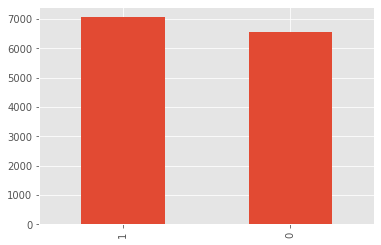

In [ ]:
df.label.value_counts().plot(kind="bar")
lab=df.label.value_counts().plot(kind="bar")
#lab.savefig('labelcount.png')

In [ ]:
lab.figure.savefig("labelcount.png")

In [ ]:
train_df=df

In [ ]:
train_df

,image,label
0,data_image/california_wildfires/10_10_2017/917...,1
1,data_image/california_wildfires/10_10_2017/917...,0
2,data_image/california_wildfires/10_10_2017/917...,1
3,data_image/california_wildfires/10_10_2017/917...,1
4,data_image/california_wildfires/10_10_2017/917...,1
...,...,...
13603,data_image/hurricane_maria/25_9_2017/912341945...,1
13604,data_image/hurricane_irma/19_9_2017/9099366121...,0
13605,data_image/hurricane_harvey/7_9_2017/905581858...,0
13606,data_image/hurricane_irma/18_9_2017/9098797465...,0


In [ ]:
test_df = pd.read_csv(os.path.join("/content/drive/MyDrive/CRISIS_1/task_informative_text_img_dev.csv"))
test_df.head()

,event_name,tweet_id,image_id,tweet_text,image,label,label_text,label_image,label_text_image
0,iraq_iran_earthquake,931465546129989632,931465546129989632_0,#Iran #earthquake damage put at over 5bn pound...,data_image/iraq_iran_earthquake/17_11_2017/931...,not_informative,informative,not_informative,Negative
1,hurricane_harvey,905064623199719425,905064623199719425_0,We've lost track of how many houses/families @...,data_image/hurricane_harvey/5_9_2017/905064623...,informative,informative,informative,Positive
2,hurricane_maria,922857566220283904,922857566220283904_0,The gym above subway got destroyed. The cement...,data_image/hurricane_maria/24_10_2017/92285756...,informative,informative,informative,Positive
3,hurricane_irma,909767231411769344,909767231411769344_0,Famous Captive Orca Fends For Herself In Flori...,data_image/hurricane_irma/18_9_2017/9097672314...,informative,informative,not_informative,Negative
4,california_wildfires,920571592131915777,920571592131915777_0,Californiaâ€™s Sausalito Fire In Marin Capture...,data_image/california_wildfires/18_10_2017/920...,informative,informative,informative,Positive


In [ ]:
selected_columns=test_df[['image','label_image']]
test_df=selected_columns.copy()

In [ ]:
code = []

for i in range(test_df.shape[0]):
    if (test_df.iloc[i]['label_image']=='informative'):
        code.append(1)
    elif (test_df.iloc[i]['label_image']=='not_informative'):
        code.append(0)
    else:
        poke_type.append('NaN')
        code.append('NaN')
test_df['label'] = code
test_df = test_df

test_df.reset_index(drop=True, inplace=True)

In [ ]:
test_df.drop('label_image',axis = 1,inplace=True)

In [ ]:
test_df

,image,label
0,data_image/iraq_iran_earthquake/17_11_2017/931...,0
1,data_image/hurricane_harvey/5_9_2017/905064623...,1
2,data_image/hurricane_maria/24_10_2017/92285756...,1
3,data_image/hurricane_irma/18_9_2017/9097672314...,0
4,data_image/california_wildfires/18_10_2017/920...,1
...,...,...
2232,data_image/hurricane_maria/21_10_2017/92184296...,1
2233,data_image/mexico_earthquake/21_9_2017/9106586...,1
2234,data_image/hurricane_harvey/9_9_2017/906341151...,0
2235,data_image/hurricane_maria/10_11_2017/92882227...,0


In [ ]:
train_df

,image,label
0,data_image/california_wildfires/10_10_2017/917...,1
1,data_image/california_wildfires/10_10_2017/917...,0
2,data_image/california_wildfires/10_10_2017/917...,1
3,data_image/california_wildfires/10_10_2017/917...,1
4,data_image/california_wildfires/10_10_2017/917...,1
...,...,...
13603,data_image/hurricane_maria/25_9_2017/912341945...,1
13604,data_image/hurricane_irma/19_9_2017/9099366121...,0
13605,data_image/hurricane_harvey/7_9_2017/905581858...,0
13606,data_image/hurricane_irma/18_9_2017/9098797465...,0


In [ ]:
class CassavaDataset(torch.utils.data.Dataset):
    """
    Helper Class to create the pytorch dataset
    """
    
    def __init__(self, df, data_path="/content/drive/MyDrive", mode="train", transforms=None):
        super().__init__()
        self.df_data = df.values
        self.data_path = data_path
        self.transforms = transforms
        self.mode = mode
        self.data_dir = "data_image" if mode == "train" else "data_image"

    def __len__(self):
        return len(self.df_data)

    def __getitem__(self, index):
        img_name, label = self.df_data[index]
        img_path = os.path.join(self.data_path, self.data_dir, img_name)
        img = Image.open(img_path).convert("RGB")

        if self.transforms is not None:
            image = self.transforms(img)

        return image, label

In [ ]:
# create image augmentations
transforms_train = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.RandomResizedCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

transforms_valid = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

In [ ]:
print("Available Vision Transformer Models: ")
timm.list_models("vit*")

Available Vision Transformer Models: 


['vit_base_patch8_224',
 'vit_base_patch8_224_in21k',
 'vit_base_patch16_224',
 'vit_base_patch16_224_in21k',
 'vit_base_patch16_224_miil',
 'vit_base_patch16_224_miil_in21k',
 'vit_base_patch16_384',
 'vit_base_patch16_sam_224',
 'vit_base_patch32_224',
 'vit_base_patch32_224_in21k',
 'vit_base_patch32_384',
 'vit_base_patch32_sam_224',
 'vit_base_r26_s32_224',
 'vit_base_r50_s16_224',
 'vit_base_r50_s16_224_in21k',
 'vit_base_r50_s16_384',
 'vit_base_resnet26d_224',
 'vit_base_resnet50_224_in21k',
 'vit_base_resnet50_384',
 'vit_base_resnet50d_224',
 'vit_giant_patch14_224',
 'vit_gigantic_patch14_224',
 'vit_huge_patch14_224',
 'vit_huge_patch14_224_in21k',
 'vit_large_patch16_224',
 'vit_large_patch16_224_in21k',
 'vit_large_patch16_384',
 'vit_large_patch32_224',
 'vit_large_patch32_224_in21k',
 'vit_large_patch32_384',
 'vit_large_r50_s32_224',
 'vit_large_r50_s32_224_in21k',
 'vit_large_r50_s32_384',
 'vit_small_patch16_224',
 'vit_small_patch16_224_in21k',
 'vit_small_patch16_3

In [ ]:
MODEL_PATH = (
    "/content/drive/MyDrive/jx_vit_base_p16_224-80ecf9dd.pth"
)

In [ ]:
DATA_PATH = "/content/drive/MyDrive"

In [ ]:
class ViTBase16(nn.Module):
    def __init__(self, n_classes, pretrained=False):

        super(ViTBase16, self).__init__()

        self.model = timm.create_model("vit_base_patch16_224", pretrained=False)
        if pretrained:
            self.model.load_state_dict(torch.load(MODEL_PATH))

        self.model.head = nn.Linear(self.model.head.in_features, n_classes)

    def forward(self, x):
        x = self.model(x)
        return x

    def train_one_epoch(self, train_loader, criterion, optimizer, device):
        # keep track of training loss
        epoch_loss = 0.0
        epoch_accuracy = 0.0

        ###################
        # train the model #
        ###################
        self.model.train()
        for i, (data, target) in enumerate(train_loader):
            # move tensors to GPU if CUDA is available
            if device.type == "cuda":
                data, target = data.cuda(), target.cuda()
            elif device.type == "xla":
                data = data.to(device, dtype=torch.float32)
                target = target.to(device, dtype=torch.int64)

            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = self.forward(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # Calculate Accuracy
            accuracy = (output.argmax(dim=1) == target).float().mean()
            # update training loss and accuracy
            epoch_loss += loss
            epoch_accuracy += accuracy

            # perform a single optimization step (parameter update)
            if device.type == "xla":
                xm.optimizer_step(optimizer)

                if i % 20 == 0:
                    xm.master_print(f"\tBATCH {i+1}/{len(train_loader)} - LOSS: {loss}")

            else:
                optimizer.step()

        return epoch_loss / len(train_loader), epoch_accuracy / len(train_loader)

    def validate_one_epoch(self, valid_loader, criterion, device):
        # keep track of validation loss
        valid_loss = 0.0
        valid_accuracy = 0.0

        ######################
        # validate the model #
        ######################
        self.model.eval()
        for data, target in valid_loader:
            # move tensors to GPU if CUDA is available
            if device.type == "cuda":
                data, target = data.cuda(), target.cuda()
            elif device.type == "xla":
                data = data.to(device, dtype=torch.float32)
                target = target.to(device, dtype=torch.int64)

            with torch.no_grad():
                # forward pass: compute predicted outputs by passing inputs to the model
                output = self.model(data)
                # calculate the batch loss
                loss = criterion(output, target)
                # Calculate Accuracy
                accuracy = (output.argmax(dim=1) == target).float().mean()
                # update average validation loss and accuracy
                valid_loss += loss
                valid_accuracy += accuracy

        return valid_loss / len(valid_loader), valid_accuracy / len(valid_loader)

In [ ]:
def fit_tpu(
    model, epochs, device, criterion, optimizer, train_loader, valid_loader=None
):

    valid_loss_min = np.Inf  # track change in validation loss
    # global acc
    # keeping track of losses as it happen
    train_losses = []
    valid_losses = []
    train_accs = []
    valid_accs = []

    for epoch in range(1, epochs + 1):
        gc.collect()
        para_train_loader = pl.ParallelLoader(train_loader, [device])

        xm.master_print(f"{'='*50}")
        xm.master_print(f"EPOCH {epoch} - TRAINING...")
        train_loss, train_acc = model.train_one_epoch(
            para_train_loader.per_device_loader(device), criterion, optimizer, device
        )
        xm.master_print(
            f"\n\t[TRAIN] EPOCH {epoch} - LOSS: {train_loss}, ACCURACY: {train_acc}\n"
        )
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        gc.collect()

        if valid_loader is not None:
            gc.collect()
            para_valid_loader = pl.ParallelLoader(valid_loader, [device])
            xm.master_print(f"EPOCH {epoch} - VALIDATING...")
            valid_loss, valid_acc = model.validate_one_epoch(
                para_valid_loader.per_device_loader(device), criterion, device
            )
            xm.master_print(f"\t[VALID] LOSS: {valid_loss}, ACCURACY: {valid_acc}\n")
            valid_losses.append(valid_loss)
            valid_accs.append(valid_acc)
            # if(valid_acc>acc):
            #   acc=valid_acc
            # if(epoch==1):
            #   print(f'final accuracy:{acc}')
            # # print(f"accuracy:{acc}\n")
            # # print(f"validaccuracy:{valid_acc}\n")
            gc.collect()

            # save model if validation loss has decreased
            if valid_loss <= valid_loss_min and epoch != 1:
                xm.master_print(
                    "Validation loss decreased ({:.4f} --> {:.4f}).  Saving model ...".format(
                        valid_loss_min, valid_loss
                    )
                )
            #                 xm.save(model.state_dict(), 'best_model.pth')

            valid_loss_min = valid_loss

    return {
        "train_loss": train_losses,
        "valid_losses": valid_losses,
        "train_acc": train_accs,
        "valid_acc": valid_accs
    }

In [ ]:
model = ViTBase16(n_classes=2, pretrained=True)

In [ ]:
PATH='/content/drive/MyDrive/model_5e_20220415-1317.pth'

In [ ]:
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
from torch.utils.data import Dataset, DataLoader

In [ ]:
def create_dataframe(data):
  df_image= pd.DataFrame(data = [data[0]],columns=['image','label_image'])
  df_text=pd.DataFrame(data=[data[1]],columns=['tweet_text','label_text'])
  return df_image,df_text


In [ ]:
transforms_test = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.RandomResizedCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

In [ ]:
def create_image_Dataset(data_image):
  image_dataset=CassavaDataset(
    data_image,
    transforms=transforms_test)
  return image_dataset

In [ ]:
def create_image_loader(image_dataset):
  image_loader =  DataLoader(
        image_dataset,
        batch_size=1,
        num_workers=2,
        shuffle=False)
  # device = xm.xla_device()
  return image_loader
 

In [ ]:
device = xm.xla_device()

TEXT FUNCTIONS

In [ ]:
# Install transformers library.
!pip install -q git+https://github.com/huggingface/transformers.git
# Install helper functions.
!pip install -q git+https://github.com/gmihaila/ml_things.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [ ]:
!python -m pip uninstall matplotlib
!pip install matplotlib==3.1.3

Found existing installation: matplotlib 3.5.1
Uninstalling matplotlib-3.5.1:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.5.1-py3.7-nspkg.pth
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.5.1.dist-info/*
    /usr/local/lib/python3.7/dist-packages/matplotlib/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid1/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axisartist/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/tests/*
    /usr/local/lib/python3.7/dist-packages/pylab.py
Proceed (y/n)? ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/base_command.py", line 180, in _main
    status = self.run(options, args)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/commands/uninstall.py", line 8

In [ ]:
import io
import os
import torch
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from ml_things import plot_dict, plot_confusion_matrix, fix_text
from sklearn.metrics import classification_report, accuracy_score
from transformers import (set_seed,
                          TrainingArguments,
                          Trainer,
                          GPT2Config,
                          GPT2Tokenizer,
                          AdamW, 
                          get_linear_schedule_with_warmup,
                          GPT2ForSequenceClassification)

# Set seed for reproducibility.
set_seed(123)
# Number of training epochs (authors on fine-tuning Bert recommend between 2 and 4).
epochs = 1

# Number of batches - depending on the max sequence length and GPU memory.
# For 512 sequence length batch of 10 works without cuda memory issues.
# For small sequence length can try batch of 32 or higher.
batch_size = 32

# Pad or truncate text sequences to a specific length
# if `None` it will use maximum sequence of word piece tokens allowed by model.
max_length = 60

# Look for gpu to use. Will use `cpu` by default if no gpu found.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Name of transformers model - will use already pretrained model.
# Path of transformer model - will load your own model from local disk.
model_name_or_path = 'gpt2'

# Dictionary of labels and their id - this will be used to convert.
# String labels to number ids.
labels_ids = {'not_informative': 0, 'informative': 1}
# How many labels are we using in training.
# This is used to decide size of classification head.
n_labels = len(labels_ids)


/usr/local/lib/python3.7/dist-packages/scipy/fft/__init__.py:97: DeprecationWarning: The module numpy.dual is deprecated.  Instead of using dual, use the functions directly from numpy or scipy.
  from numpy.dual import register_func
/usr/local/lib/python3.7/dist-packages/scipy/sparse/sputils.py:17: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  supported_dtypes = [np.typeDict[x] for x in supported_dtypes]
/usr/local/lib/python3.7/dist-packages/scipy/sparse/sputils.py:17: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  supported_dtypes = [np.typeDict[x] for x in supported_dtypes]
/usr/local/lib/python3.7/dist-packages/scipy/sparse/sputils.py:17: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  supported_dtypes = [np.typeDict[x] for x in supported_dtypes]
/usr/local/lib/python3.7/dist-packages/scipy/sparse/sputils.py:17: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.

In [ ]:
class MovieReviewsDataset(Dataset):
  r"""PyTorch Dataset class for loading data.

  This is where the data parsing happens.

  This class is built with reusability in mind: it can be used as is as.

  Arguments:

    path (:obj:`str`):
        Path to the data partition.

  """

  def __init__(self, path, use_tokenizer):

    # Check if path exists.
    #if not os.path.isdir(path):
      # Raise error if path is invalid.
     # raise ValueError('Invalid `path` variable! Needs to be a directory')
    a=pd.read_csv('/content/drive/MyDrive/CRISIS_1/task_informative_text_img_train.csv')
    #a=a[1:2]
    self.texts = []
    self.labels = []
   
    for content in a['tweet_text']:
       self.texts.append(content)
    # Since the labels are defined by folders with data we loop 
     # through each label.
    for label in a['label_text']:
       self.labels.append(label)
    # for label in ['informative', 'not_informative']:
    #   sentiment_path = os.path.join('/content/drive/MyDrive/CRISIS_1-20220401T060043Z-001/CRISIS_1/', label)

    #   # Get all files from path.
    #   files_names = os.listdir(sentiment_path)#[:10] # Sample for debugging.
    #   # Go through each file and read its content.
    #   for file_name in tqdm(files_names, desc=f'{label} files'):
    #     file_path = os.path.join(sentiment_path, file_name)

    #     # Read content.
    #     content = io.open(file_path, mode='r', encoding='utf-8').read()
    #     # Fix any unicode issues.
    #     content = fix_text(content)
    #     # Save content.
    #     self.texts.append(content)
    #     # Save encode labels.
    #     self.labels.append(label)
         # Number of exmaples.
    self.n_examples = len(self.labels)
    

    return

  def __len__(self):
    r"""When used `len` return the number of examples.

    """
    
    return self.n_examples

  def __getitem__(self, item):
    r"""Given an index return an example from the position.
    
    Arguments:

      item (:obj:`int`):
          Index position to pick an example to return.
          Returns:
      :obj:`Dict[str, str]`: Dictionary of inputs that contain text and 
      asociated labels.

    """

    return {'text':self.texts[item],
            'label':self.labels[item]}


In [ ]:
class MovieReviewsDatasetvalid(Dataset):
  r"""PyTorch Dataset class for loading data.

  This is where the data parsing happens.

  This class is built with reusability in mind: it can be used as is as.

  Arguments:

    path (:obj:`str`):
        Path to the data partition.

  """

  def __init__(self, path, use_tokenizer):

    # Check if path exists.
    #if not os.path.isdir(path):
      # Raise error if path is invalid.
     # raise ValueError('Invalid `path` variable! Needs to be a directory')
    a=pd.read_csv('/content/drive/MyDrive/CRISIS_1/task_informative_text_img_dev.csv')
    #a=a[1:2]
    self.texts = []
    self.labels = []
   
    for content in a['tweet_text']:
       self.texts.append(content)
    # Since the labels are defined by folders with data we loop 
     # through each label.
    for label in a['label_text']:
       self.labels.append(label)
    # for label in ['informative', 'not_informative']:
    #   sentiment_path = os.path.join('/content/drive/MyDrive/CRISIS_1-20220401T060043Z-001/CRISIS_1/', label)

    #   # Get all files from path.
    #   files_names = os.listdir(sentiment_path)#[:10] # Sample for debugging.
    #   # Go through each file and read its content.
    #   for file_name in tqdm(files_names, desc=f'{label} files'):
    #     file_path = os.path.join(sentiment_path, file_name)

    #     # Read content.
    #     content = io.open(file_path, mode='r', encoding='utf-8').read()
    #     # Fix any unicode issues.
    #     content = fix_text(content)
    #     # Save content.
    #     self.texts.append(content)
    #     # Save encode labels.
    #     self.labels.append(label)
         # Number of exmaples.
    self.n_examples = len(self.labels)
    

    return

  def __len__(self):
    r"""When used `len` return the number of examples.

    """
    
    return self.n_examples

  def __getitem__(self, item):
    r"""Given an index return an example from the position.
    
    Arguments:

      item (:obj:`int`):
          Index position to pick an example to return.
          Returns:
      :obj:`Dict[str, str]`: Dictionary of inputs that contain text and 
      asociated labels.

    """

    return {'text':self.texts[item],
            'label':self.labels[item]}


In [ ]:
class MovieReviewsDataset_test(Dataset):
  r"""PyTorch Dataset class for loading data.

  This is where the data parsing happens.

  This class is built with reusability in mind: it can be used as is as.

  Arguments:

    path (:obj:`str`):
        Path to the data partition.

  """

  def __init__(self, path, use_tokenizer):

    # Check if path exists.
    #if not os.path.isdir(path):
      # Raise error if path is invalid.
     # raise ValueError('Invalid `path` variable! Needs to be a directory')
    a=pd.read_csv('/content/drive/MyDrive/CRISIS_1/task_informative_text_img_test.csv')
    a=a[1:2]
    #a=a[:50]
    # print('printig df1')
    # print(df1)
    # a=df1
    self.texts = []
    self.labels = []
   
    for content in a['tweet_text']:
       self.texts.append(content)
    # Since the labels are defined by folders with data we loop 
     # through each label.
    for label in a['label_text']:
       self.labels.append(label)
    # for label in ['informative', 'not_informative']:
    #   sentiment_path = os.path.join('/content/drive/MyDrive/CRISIS_1-20220401T060043Z-001/CRISIS_1/', label)

    #   # Get all files from path.
    #   files_names = os.listdir(sentiment_path)#[:10] # Sample for debugging.
    #   # Go through each file and read its content.
    #   for file_name in tqdm(files_names, desc=f'{label} files'):
    #     file_path = os.path.join(sentiment_path, file_name)

    #     # Read content.
    #     content = io.open(file_path, mode='r', encoding='utf-8').read()
    #     # Fix any unicode issues.
    #     content = fix_text(content)
    #     # Save content.
    #     self.texts.append(content)
    #     # Save encode labels.
    #     self.labels.append(label)
         # Number of exmaples.
    self.n_examples = len(self.labels)
    

    return

  def __len__(self):
    r"""When used `len` return the number of examples.

    """
    
    return self.n_examples

  def __getitem__(self, item):
    r"""Given an index return an example from the position.
    
    Arguments:

      item (:obj:`int`):
          Index position to pick an example to return.
          Returns:
      :obj:`Dict[str, str]`: Dictionary of inputs that contain text and 
      asociated labels.

    """

    return {'text':self.texts[item],
            'label':self.labels[item]}

In [ ]:
class Gpt2ClassificationCollator(object):
    r"""
    Data Collator used for GPT2 in a classificaiton rask. 
    
    It uses a given tokenizer and label encoder to convert any text and labels to numbers that 
    can go straight into a GPT2 model.

    This class is built with reusability in mind: it can be used as is as long
    as the `dataloader` outputs a batch in dictionary format that can be passed 
    straight into the model - `model(**batch)`.

    Arguments:

      use_tokenizer (:obj:`transformers.tokenization_?`):
          Transformer type tokenizer used to process raw text into numbers.

      labels_ids (:obj:`dict`):
          Dictionary to encode any labels names into numbers. Keys map to 
          labels names and Values map to number associated to those labels.

      max_sequence_len (:obj:`int`, `optional`)
          Value to indicate the maximum desired sequence to truncate or pad text
          sequences. If no value is passed it will used maximum sequence size
          supported by the tokenizer and model.

    """

    def __init__(self, use_tokenizer, labels_encoder, max_sequence_len=None):

        # Tokenizer to be used inside the class.
        self.use_tokenizer = use_tokenizer
        # Check max sequence length.
        self.max_sequence_len = use_tokenizer.model_max_length if max_sequence_len is None else max_sequence_len
        # Label encoder used inside the class.
        self.labels_encoder = labels_encoder

        return

    def __call__(self, sequences):
        r"""
        This function allowes the class objesct to be used as a function call.
        Sine the PyTorch DataLoader needs a collator function, I can use this 
        class as a function.

        Arguments:

          item (:obj:`list`):
              List of texts and labels.

        Returns:
          :obj:`Dict[str, object]`: Dictionary of inputs that feed into the model.
          It holddes the statement `model(**Returned Dictionary)`.
        """

        # Get all texts from sequences list.
        texts = [sequence['text'] for sequence in sequences]
        # Get all labels from sequences list.
        labels = [sequence['label'] for sequence in sequences]
        # Encode all labels using label encoder.
        labels = [self.labels_encoder[label] for label in labels]
        # Call tokenizer on all texts to convert into tensors of numbers with 
        # appropriate padding.
        inputs = self.use_tokenizer(text=texts, return_tensors="pt", padding=True, truncation=True,  max_length=self.max_sequence_len)
        # Update the inputs with the associated encoded labels as tensor.
        inputs.update({'labels':torch.tensor(labels)})

        return inputs


def train(dataloader, optimizer_, scheduler_, device_):
  r"""
  Train pytorch model on a single pass through the data loader.

  It will use the global variable `model` which is the transformer model 
  loaded on `_device` that we want to train on.

  This function is built with reusability in mind: it can be used as is as long
    as the `dataloader` outputs a batch in dictionary format that can be passed 
    straight into the model - `model(**batch)`.

  Arguments:

      dataloader (:obj:`torch.utils.data.dataloader.DataLoader`):
          Parsed data into batches of tensors.

      optimizer_ (:obj:`transformers.optimization.AdamW`):
          Optimizer used for training.

      scheduler_ (:obj:`torch.optim.lr_scheduler.LambdaLR`):
          PyTorch scheduler.

      device_ (:obj:`torch.device`):
          Device used to load tensors before feeding to model.

  Returns:

      :obj:`List[List[int], List[int], float]`: List of [True Labels, Predicted
        Labels, Train Average Loss].
  """

  # Use global variable for model.
  global model_text

  # Tracking variables.
  predictions_labels = []
  true_labels = []
  # Total loss for this epoch.
  total_loss = 0

  # Put the model into training mode.
  model_text.train()

  # For each batch of training data...
  for batch in tqdm(dataloader, total=len(dataloader)):

    # Add original labels - use later for evaluation.
    true_labels += batch['labels'].numpy().flatten().tolist()
    #print(batch.items())
    # move batch to device
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}
    # Always clear any previously calculated gradients before performing a
    # backward pass.
    model_text.zero_grad()

    # Perform a forward pass (evaluate the model on this training batch).
    # This will return the loss (rather than the model output) because we
    # have provided the `labels`.
    # The documentation for this a bert model function is here: 
    # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
    outputs = model_text(**batch)
    # The call to `model` always returns a tuple, so we need to pull the 
    # loss value out of the tuple along with the logits. We will use logits
    # later to calculate training accuracy.
    loss, logits = outputs[:2]

    # Accumulate the training loss over all of the batches so that we can
    # calculate the average loss at the end. `loss` is a Tensor containing a
    # single value; the `.item()` function just returns the Python value 
    # from the tensor.
    total_loss += loss.item()

    # Perform a backward pass to calculate the gradients.
    loss.backward()

    # Clip the norm of the gradients to 1.0.
    # This is to help prevent the "exploding gradients" problem.
    torch.nn.utils.clip_grad_norm_(model_text.parameters(), 1.0)

    # Update parameters and take a step using the computed gradient.
    # The optimizer dictates the "update rule"--how the parameters are
    # modified based on their gradients, the learning rate, etc.
    optimizer_.step()

    # Update the learning rate.
    scheduler_.step()

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()

    # Convert these logits to list of predicted labels values.
    predictions_labels += logits.argmax(axis=-1).flatten().tolist()
    #print(predictions_labels)
  # Calculate the average loss over the training data.
  avg_epoch_loss = total_loss / len(dataloader)
  
  # Return all true labels and prediction for future evaluations.
  return true_labels, predictions_labels, avg_epoch_loss



def validation(dataloader, device_):
  r"""Validation function to evaluate model performance on a 
  separate set of data.

  This function will return the true and predicted labels so we can use later
  to evaluate the model's performance.

  This function is built with reusability in mind: it can be used as is as long
    as the `dataloader` outputs a batch in dictionary format that can be passed 
    straight into the model - `model(**batch)`.

  Arguments:

    dataloader (:obj:`torch.utils.data.dataloader.DataLoader`):
          Parsed data into batches of tensors.

    device_ (:obj:`torch.device`):
          Device used to load tensors before feeding to model.

  Returns:
    
    :obj:`List[List[int], List[int], float]`: List of [True Labels, Predicted
        Labels, Train Average Loss]
  """

  # Use global variable for model.
  global model_text

  # Tracking variables
  predictions_labels = []
  true_labels = []
  #total loss for this epoch.
  total_loss = 0

  # Put the model in evaluation mode--the dropout layers behave differently
  # during evaluation.
  model_text.eval()

  # Evaluate data for one epoch
  for batch in tqdm(dataloader, total=len(dataloader)):

    # add original labels
    true_labels += batch['labels'].numpy().flatten().tolist()

    # move batch to device
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}

    # Telling the model not to compute or store gradients, saving memory and
    # speeding up validation
    with torch.no_grad():        

        # Forward pass, calculate logit predictions.
        # This will return the logits rather than the loss because we have
        # not provided labels.
        # token_type_ids is the same as the "segment ids", which 
        # differentiates sentence 1 and 2 in 2-sentence tasks.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model_text(**batch)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple along with the logits. We will use logits
        # later to to calculate training accuracy.
        loss, logits = outputs[:2]
        
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()
        
        # get predicitons to list
        predict_content = logits.argmax(axis=-1).flatten().tolist()

        # update list
        predictions_labels += predict_content
        #print(predictions_labels)

  # Calculate the average loss over the training data.
  avg_epoch_loss = total_loss / len(dataloader)

  # Return all true labels and prediciton for future evaluations.
  return true_labels, predictions_labels, avg_epoch_loss
  
def test(dataloader, device_):
  r"""Validation function to evaluate model performance on a 
  separate set of data.

  This function will return the true and predicted labels so we can use later
  to evaluate the model's performance.

  This function is built with reusability in mind: it can be used as is as long
    as the `dataloader` outputs a batch in dictionary format that can be passed 
    straight into the model - `model(**batch)`.

  Arguments:

    dataloader (:obj:`torch.utils.data.dataloader.DataLoader`):
          Parsed data into batches of tensors.

    device_ (:obj:`torch.device`):
          Device used to load tensors before feeding to model.

  Returns:
    
    :obj:`List[List[int], List[int], float]`: List of [True Labels, Predicted
        Labels, Train Average Loss]
  """

  # Use global variable for model.
  global model_text

  # Tracking variables
  predictions_labels = []
  true_labels = []
  #total loss for this epoch.
  total_loss = 0

  # Put the model in evaluation mode--the dropout layers behave differently
  # during evaluation.
  model_text.eval()

  # Evaluate data for one epoch
  for batch in tqdm(dataloader, total=len(dataloader)):

    # add original labels
    true_labels += batch['labels'].numpy().flatten().tolist()

    # move batch to device
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}

    # Telling the model not to compute or store gradients, saving memory and
    # speeding up validation
    with torch.no_grad():        

        # Forward pass, calculate logit predictions.
        # This will return the logits rather than the loss because we have
        # not provided labels.
        # token_type_ids is the same as the "segment ids", which 
        # differentiates sentence 1 and 2 in 2-sentence tasks.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model_text(**batch)

        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple along with the logits. We will use logits
        # later to to calculate training accuracy.
        loss, logits = outputs[:2]
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()
        
        # get predicitons to list
        predict_content = logits.argmax(axis=-1).flatten().tolist()

        # update list
        predictions_labels += predict_content
        #print(predictions_labels)

  # Calculate the average loss over the training data.
  avg_epoch_loss = total_loss / len(dataloader)

  # Return all true labels and prediciton for future evaluations.
  return true_labels, predictions_labels, avg_epoch_loss

In [ ]:
import joblib
# Get model configuration.
print('Loading configuraiton...')
model_config = GPT2Config.from_pretrained(pretrained_model_name_or_path=model_name_or_path, num_labels=n_labels)

# Get model's tokenizer.
print('Loading tokenizer...')
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_name_or_path=model_name_or_path)
# default to left padding
tokenizer.padding_side = "left"
# Define PAD Token = EOS Token = 50256
tokenizer.pad_token = tokenizer.eos_token


# Get the actual model.
print('Loading model...')
#model_text = GPT2ForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name_or_path, config=model_config)
model_text= joblib.load('/content/drive/MyDrive/textmodelGPT2.pkl')
# resize model embedding to match new tokenizer
model_text.resize_token_embeddings(len(tokenizer))

# fix model padding token id
model_text.config.pad_token_id = model_text.config.eos_token_id

# Load model to defined device.
model_text.to(device)
print('Model loaded to `%s`'%device)

Loading configuraiton...
Loading tokenizer...
Loading model...
Model loaded to `cpu`


In [ ]:
import pandas as pd
gpt2_classificaiton_collator = Gpt2ClassificationCollator(use_tokenizer=tokenizer, 
                                                          labels_encoder=labels_ids, 
                                                          max_sequence_len=max_length)

Created `test_dataset` with 1 examples!
Created `eval_dataloader` with 1 batches!


IMAGE PREDICTION

In [ ]:
if __name__ == '__main__':
  data=[['data_image/california_wildfires/11_10_2017/917914955118272513_0.jpg',1],['fire',1]]

  #IMAGE PREDICTIONS
  df_image,df_text=create_dataframe(data)
  image_dataset=create_image_Dataset(df_image)
  image_loader=create_image_loader(image_dataset)
  predictions=[]
  predict_image=[]
  for imgs,target in image_loader:
    imgs = imgs.to(device, dtype=torch.float32)
    with torch.no_grad():
      model=model.to(device)
      outputs = model(imgs)
      _, predicted = torch.max(outputs, dim=1)
      predicted=predicted.to('cpu')
      predictions.append(predicted)
      predict_image.append(outputs.argmax(dim=1).cpu().item())
  print(predict_image)

[1]


TEXT PREDICTION

In [ ]:
if __name__ == '__main__':
  data=[['data_image/california_wildfires/11_10_2017/917914955118272513_0.jpg',1],['fire','informative']]

  #TEXT PREDICTIONS
  df_image,df_text=create_dataframe(data)
  test_dataset = MovieReviewsDataset_test(df_text,use_tokenizer=tokenizer)
  print('Created `test_dataset` with %d examples!'%len(test_dataset))
  test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)
  print('Created `eval_dataloader` with %d batches!'%len(test_dataloader))
  tokenizer.pad_token = tokenizer.eos_token
  test_labels, predict_text, test_loss=test(test_dataloader, device)
  print(predict_text)

Created `test_dataset` with 1 examples!
Created `eval_dataloader` with 1 batches!


  0%|          | 0/1 [00:00<?, ?it/s]

[1]


FINAL PREDICTIONS

In [ ]:
final_model= joblib.load('/content/drive/MyDrive/randomforestclassifier1.pkl')

In [ ]:
predict_text

[1]

In [ ]:
predict_image

[1]

In [ ]:
dict={'image':predict_image,'text':predict_text}

In [ ]:
df=pd.DataFrame(dict)

In [ ]:
df

,image,text
0,1,1


In [ ]:
def predict(df):
  for index,rows in df.iterrows():
    prediction_array=np.column_stack((rows['image'],rows['text']))
    a=final_model.predict(prediction_array)
  return a

In [ ]:
if __name__ == '__main__':
  final_model= joblib.load('/content/drive/MyDrive/randomforestclassifier1.pkl')
  dict={'image':predict_image,'text':predict_text}
  df=pd.DataFrame(dict)
  final_prediction=predict(df)
  if(final_prediction==1):
    print('Tweet text and image informative')
  else:
    print('Tweet text and image not informative')

Tweet text and image informative


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


IMAGE GRAPHS

In [ ]:
import pandas as pd
import os

In [ ]:
test_df = pd.read_csv(os.path.join("/content/drive/MyDrive/CRISIS_1/task_informative_text_img_test.csv"))
test_df.head()

,event_name,tweet_id,image_id,tweet_text,image,label,label_text,label_image,label_text_image
0,srilanka_floods,878185882431389696,878185882431389696_0,Cristofer CLEMENTE MORA now in 2nd at aguille ...,data_image/srilanka_floods/23_6_2017/878185882...,not_informative,not_informative,not_informative,Positive
1,hurricane_harvey,906258753707790336,906258753707790336_0,RT @THS_College: On our way to Warrior Restora...,data_image/hurricane_harvey/8_9_2017/906258753...,not_informative,informative,not_informative,Negative
2,hurricane_maria,910542719864397824,910542719864397824_0,Hurricane Maria batters Puerto Rico as a Cat 4...,data_image/hurricane_maria/20_9_2017/910542719...,informative,informative,informative,Positive
3,hurricane_harvey,906219963152785408,906219963152785408_0,ZZ Top Donating ‘La Grange’ Download Sales To ...,data_image/hurricane_harvey/8_9_2017/906219963...,informative,informative,not_informative,Negative
4,hurricane_maria,913009824195104768,913009824195104768_0,8am #Maria update: holding steady as a strong ...,data_image/hurricane_maria/27_9_2017/913009824...,informative,informative,informative,Positive


In [ ]:
selected_columns=test_df[['image','label_image']]
test_df=selected_columns.copy()

In [ ]:
code = []

for i in range(test_df.shape[0]):
    if (test_df.iloc[i]['label_image']=='informative'):
        code.append(1)
    elif (test_df.iloc[i]['label_image']=='not_informative'):
        code.append(0)
    else:
        poke_type.append('NaN')
        code.append('NaN')
test_df['label'] = code
test_df = test_df

test_df.reset_index(drop=True, inplace=True)

In [ ]:
test_df.drop('label_image',axis = 1,inplace=True)

In [ ]:
test_df

,image,label
0,data_image/srilanka_floods/23_6_2017/878185882...,0
1,data_image/hurricane_harvey/8_9_2017/906258753...,0
2,data_image/hurricane_maria/20_9_2017/910542719...,1
3,data_image/hurricane_harvey/8_9_2017/906219963...,0
4,data_image/hurricane_maria/27_9_2017/913009824...,1
...,...,...
2232,data_image/hurricane_irma/19_9_2017/9102396637...,0
2233,data_image/hurricane_irma/17_9_2017/9094682915...,1
2234,data_image/hurricane_harvey/17_9_2017/90944241...,1
2235,data_image/srilanka_floods/27_6_2017/879731058...,0


In [ ]:
test_label=test_df['label']

In [ ]:
t=pd.read_csv('/content/test_predicitons_image.csv')

In [ ]:
t

,Unnamed: 0,test_label_image
0,0,0
1,1,0
2,2,1
3,3,0
4,4,1
...,...,...
2232,2232,1
2233,2233,0
2234,2234,1
2235,2235,0


In [ ]:
test_predict=t['test_label_image']

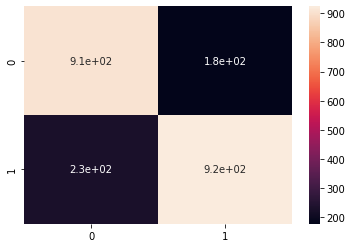

In [ ]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
cf_matrix=confusion_matrix(test_label, test_predict)
a=sns.heatmap(cf_matrix, annot=True)
a.figure.savefig('confusionmatrix_image_vit16')

In [ ]:
print(classification_report(test_label,test_predict))

              precision    recall  f1-score   support

           0       0.80      0.84      0.82      1086
           1       0.84      0.80      0.82      1151

    accuracy                           0.82      2237
   macro avg       0.82      0.82      0.82      2237
weighted avg       0.82      0.82      0.82      2237



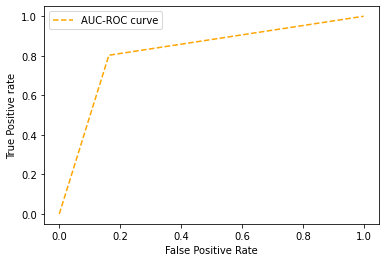

In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(test_label, test_predict, pos_label=1)
plt.plot(fpr1, tpr1, linestyle='--',color='orange',label='AUC-ROC curve')
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('ROC_image_vit16_re',dpi=300)
plt.show();


In [ ]:
from sklearn.metrics import roc_auc_score
auc_score = roc_auc_score(test_label,test_predict)
print( auc_score)

0.8198983828618881


In [ ]:
val_loss=[0.388671875,0.37109375,0.326171875, 0.3515625, 0.357421875,0.3671875,0.361328125,0.408203125,0.447265625,0.447265625]
val_acc=[0.828125,0.83984375,0.84375,0.84375,0.83984375,0.84375,0.859375, 0.8359,0.828125,0.82421875]
train_loss=[0.439453125,0.3828125,0.326171875,0.302734375,0.26953125,0.259765625, 0.232421875,0.216796875,0.1884765625,0.1982421875]
train_acc=[ 0.80078125,0.859375,0.890625, 0.88671875,0.92578125,0.92578125,0.94921875,0.9453125, 0.9609375,0.953125]

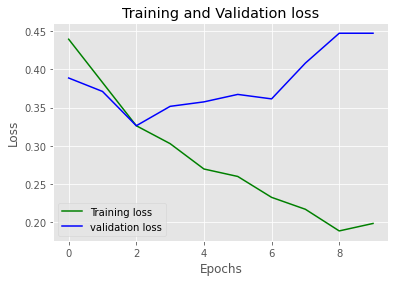

In [ ]:
plt.plot(train_loss, 'g', label='Training loss')
plt.plot(val_loss, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('train_loss_val_loss_image_vit16',dpi=400)
plt.show()


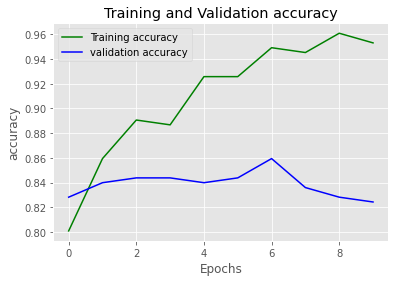

In [ ]:
plt.plot(train_acc, 'g', label='Training accuracy')
plt.plot(val_acc, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.savefig('train_acc_val_loss_acc_vit16',dpi=400)
plt.show()


TEXT GRAPHS

In [ ]:
text_test_df = pd.read_csv(os.path.join("/content/drive/MyDrive/CRISIS_1/task_informative_text_img_dev.csv"))
text_test_df.head()

,event_name,tweet_id,image_id,tweet_text,image,label,label_text,label_image,label_text_image
0,iraq_iran_earthquake,931465546129989632,931465546129989632_0,#Iran #earthquake damage put at over 5bn pound...,data_image/iraq_iran_earthquake/17_11_2017/931...,not_informative,informative,not_informative,Negative
1,hurricane_harvey,905064623199719425,905064623199719425_0,We've lost track of how many houses/families @...,data_image/hurricane_harvey/5_9_2017/905064623...,informative,informative,informative,Positive
2,hurricane_maria,922857566220283904,922857566220283904_0,The gym above subway got destroyed. The cement...,data_image/hurricane_maria/24_10_2017/92285756...,informative,informative,informative,Positive
3,hurricane_irma,909767231411769344,909767231411769344_0,Famous Captive Orca Fends For Herself In Flori...,data_image/hurricane_irma/18_9_2017/9097672314...,informative,informative,not_informative,Negative
4,california_wildfires,920571592131915777,920571592131915777_0,Californiaâ€™s Sausalito Fire In Marin Capture...,data_image/california_wildfires/18_10_2017/920...,informative,informative,informative,Positive


In [ ]:
selected_columns=text_test_df[['tweet_text','label_text']]
text_test_df=selected_columns.copy()

In [ ]:
code = []

for i in range(text_test_df.shape[0]):
    if (text_test_df.iloc[i]['label_text']=='informative'):
        code.append(1)
    elif (text_test_df.iloc[i]['label_text']=='not_informative'):
        code.append(0)
    else:
        poke_type.append('NaN')
        code.append('NaN')
text_test_df['label'] = code
text_test_df = text_test_df

text_test_df.reset_index(drop=True, inplace=True)

In [ ]:
text_test_df.drop('label_text',axis = 1,inplace=True)

In [ ]:
text_test_df

,tweet_text,label
0,#Iran #earthquake damage put at over 5bn pound...,1
1,We've lost track of how many houses/families @...,1
2,The gym above subway got destroyed. The cement...,1
3,Famous Captive Orca Fends For Herself In Flori...,1
4,Californiaâ€™s Sausalito Fire In Marin Capture...,1
...,...,...
2232,Univision News Weekly Brief: A month after the...,0
2233,OzarksFirst (KOLR): Springfield Woman's Family...,1
2234,Nana Tornado at Afia schwarâ€™s house celebrat...,0
2235,Here Are Some Weird Moments From President Tru...,0


In [ ]:
test_label=text_test_df['label']

In [ ]:
t=pd.read_csv('/content/drive/MyDrive/combinedtestpredictions.csv')

In [ ]:
test_predict=t['val_text']

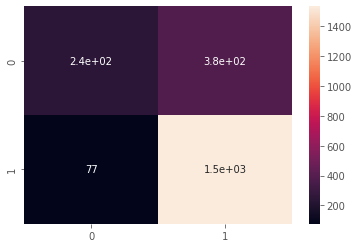

In [ ]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
cf_matrix=confusion_matrix(test_label, test_predict)
a=sns.heatmap(cf_matrix, annot=True)
#a.figure.savefig('confusionmatrix_image_vit16')

In [ ]:
print(classification_report(test_label,test_predict))

              precision    recall  f1-score   support

           0       0.76      0.39      0.52       625
           1       0.80      0.95      0.87      1612

    accuracy                           0.80      2237
   macro avg       0.78      0.67      0.69      2237
weighted avg       0.79      0.80      0.77      2237



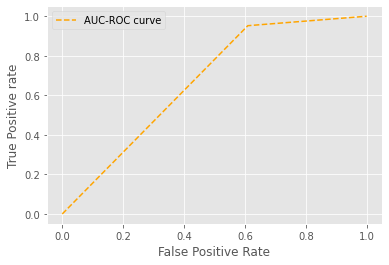

In [ ]:
from sklearn.metrics import roc_curve
# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(test_label, test_predict, pos_label=1)
plt.plot(fpr1, tpr1, linestyle='--',color='orange',label='AUC-ROC curve')
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')
plt.legend(loc='best')
#plt.savefig('ROC_image_vit16',dpi=400)
plt.show();


In [ ]:
from sklearn.metrics import roc_auc_score
auc_score = roc_auc_score(test_label,test_predict)
print( auc_score)

0.6713166253101737


In [ ]:
val_loss=[0.388671875,0.37109375,0.326171875, 0.3515625, 0.357421875,0.3671875,0.361328125,0.408203125,0.447265625,0.447265625]
val_acc=[0.828125,0.83984375,0.84375,0.84375,0.83984375,0.84375,0.859375, 0.8359,0.828125,0.82421875]
train_loss=[0.439453125,0.3828125,0.326171875,0.302734375,0.26953125,0.259765625, 0.232421875,0.216796875,0.1884765625,0.1982421875]
train_acc=[ 0.80078125,0.859375,0.890625, 0.88671875,0.92578125,0.92578125,0.94921875,0.9453125, 0.9609375,0.953125]

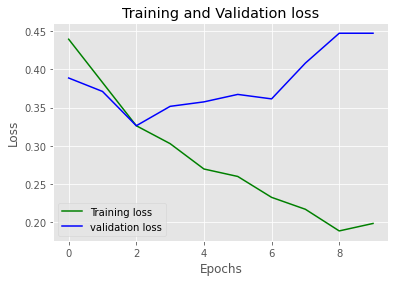

In [ ]:
plt.plot(train_loss, 'g', label='Training loss')
plt.plot(val_loss, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('train_loss_val_loss_image_vit16',dpi=400)
plt.show()


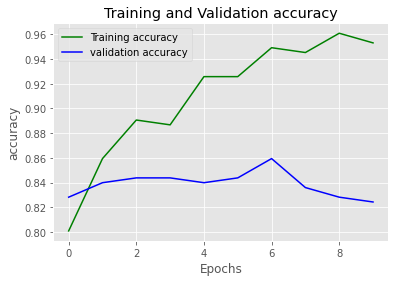

In [ ]:
plt.plot(train_acc, 'g', label='Training accuracy')
plt.plot(val_acc, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.savefig('train_acc_val_loss_acc_vit16',dpi=400)
plt.show()


FINAL GRAPHS

In [ ]:
final_test_df = pd.read_csv(os.path.join("/content/drive/MyDrive/CRISIS_1/task_informative_text_img_test.csv"))
final_test_df.head()

,event_name,tweet_id,image_id,tweet_text,image,label,label_text,label_image,label_text_image
0,srilanka_floods,878185882431389696,878185882431389696_0,Cristofer CLEMENTE MORA now in 2nd at aguille ...,data_image/srilanka_floods/23_6_2017/878185882...,not_informative,not_informative,not_informative,Positive
1,hurricane_harvey,906258753707790336,906258753707790336_0,RT @THS_College: On our way to Warrior Restora...,data_image/hurricane_harvey/8_9_2017/906258753...,not_informative,informative,not_informative,Negative
2,hurricane_maria,910542719864397824,910542719864397824_0,Hurricane Maria batters Puerto Rico as a Cat 4...,data_image/hurricane_maria/20_9_2017/910542719...,informative,informative,informative,Positive
3,hurricane_harvey,906219963152785408,906219963152785408_0,ZZ Top Donating ‘La Grange’ Download Sales To ...,data_image/hurricane_harvey/8_9_2017/906219963...,informative,informative,not_informative,Negative
4,hurricane_maria,913009824195104768,913009824195104768_0,8am #Maria update: holding steady as a strong ...,data_image/hurricane_maria/27_9_2017/913009824...,informative,informative,informative,Positive


In [ ]:
dict1={'informative':0,'not_informative':1}

In [ ]:
final_test_df.label_text.replace(dict1,inplace=True)
final_test_df.label_image.replace(dict1,inplace=True)
final_test_df.label.replace(dict1,inplace=True)

In [ ]:
xtest=final_test_df[['label_image','label_text']]

In [ ]:
import joblib
final_model= joblib.load('/content/drive/MyDrive/randomforestclassifier1.pkl')

In [ ]:
ytest=final_test_df['label']
ypred = final_model.predict(xtest)

/usr/local/lib/python3.7/dist-packages/seaborn/matrix.py:302: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  mesh = ax.pcolormesh(self.plot_data, cmap=self.cmap, **kws)
/usr/local/lib/python3.7/dist-packages/seaborn/matrix.py:312: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = ax.figure.colorbar(mesh, cax, ax, **self.cbar_kws)


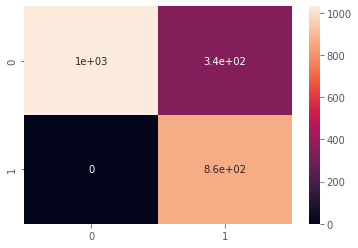

In [ ]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
cf_matrix=confusion_matrix(ytest, ypred)
a=sns.heatmap(cf_matrix, annot=True)
a.figure.savefig('confusionmatrix_final_imagetext.png')

In [ ]:
print(classification_report(ytest,ypred))

              precision    recall  f1-score   support

           0       1.00      0.75      0.86      1373
           1       0.72      1.00      0.83       864

    accuracy                           0.85      2237
   macro avg       0.86      0.88      0.85      2237
weighted avg       0.89      0.85      0.85      2237



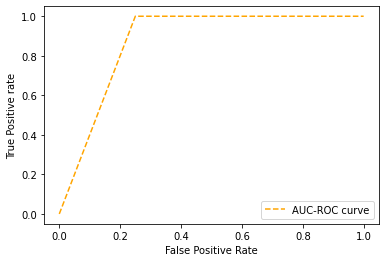

In [ ]:
from sklearn.metrics import roc_curve
# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(ytest, ypred, pos_label=1)
plt.plot(fpr1, tpr1, linestyle='--',color='orange',label='AUC-ROC curve')
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('ROC_imagetext_final_re',dpi=400)
plt.show();


In [ ]:
from sklearn.metrics import roc_auc_score
auc_score = roc_auc_score(ytest,ypred)
print( auc_score)

0.8750910415149308


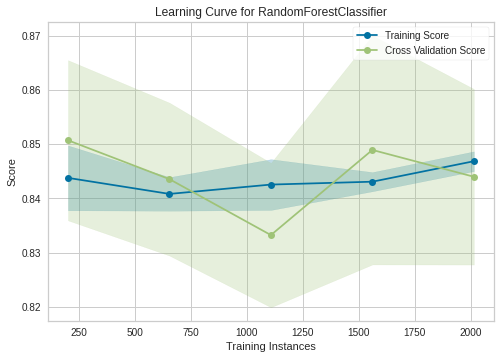

ValueError: ignored

In [ ]:
from yellowbrick.model_selection import learning_curve
print(learning_curve(final_model, xtest, ytest, cv=10, scoring='accuracy'))

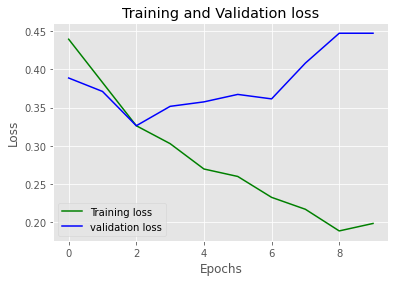

In [ ]:
plt.plot(train_loss, 'g', label='Training loss')
plt.plot(val_loss, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('train_loss_val_loss_image_vit16',dpi=400)
plt.show()


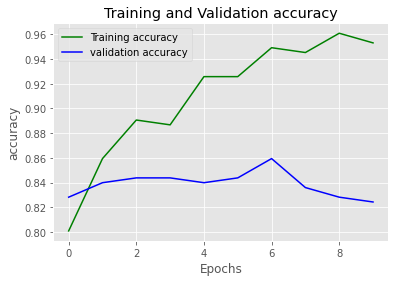

In [ ]:
plt.plot(train_acc, 'g', label='Training accuracy')
plt.plot(val_acc, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.savefig('train_acc_val_loss_acc_vit16',dpi=400)
plt.show()
